# Recognition - Classification

### Imports et installations

In [ ]:
import numpy as np
!pip install -q keras
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Mount your drive

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
!ls
print()
!ls drive
print()
!ls drive/My\ Drive

drive  sample_data

MyDrive

'aligned_images (1).tar.gz'
 aligned_images.tar.gz
'An Image is worth 16x16 Words : Transformers For Image Recognition At Scale.gslides'
 bnp-rib.pdf
 Colab
'Colab Notebooks'
'Copie de Algebra Workshop by Slidesgo.gslides'
'Copie de Propositions de stages IAAA.gsheet'
'Copie de Réunion de rentrée M2 IAAA Septembre.gslides'
 Cv_saad_Tazroute_Eng.pdf
 Cv_saad_Tazroute.pdf
'Deep Learning '
'Document de SAAD'
 Documents_Saad
'Documents stagiaire'
'Documents Visa 2021 2022'
 Donda
 ECM
'Étude de cas.gslides'
 generated_images_tiled.tar.gz
 gifs
'hmm (1).pdf'
'IMG_2990 (2).jpg'
 Inside-Two-i-S02E15-Anomalies-V2.mp4
 Kaggle
 main_CV2_21.gdoc
 Morphing
 morpho.mp4
'Music Presentation TAZROUTE.gslides'
 presentaion_Opti.gslides
 Présentation_option_ecm.gslides
'Présentation sans titre.gslides'
 Projection_+_Morphing.ipynb
'Projet Google Science Fair.gslides'
 PSTALN_test
'rapport lailouette'
'Rapport LVMT'
 Recovery
 repos
 requirementsprojet.txt
 ressourcessss

### Get the dataset

Copy the dataset on your drive. Specify the path to your dataset in the following codes ! You could use !wget as an alternative.


### List images from folders

In [ ]:
import os
#import glob

dir_path  = '/content/drive/MyDrive/ECM/ComputerVision/miniMIT_Etus/'#####################################
listDir = sorted(os.listdir(dir_path))#glob.glob(dir_path)
print(listDir)

for d in listDir:
  #read subfolder
  listFiles = sorted(os.listdir(dir_path+'/'+d))
  print(listFiles)
  print(len(listFiles))


['test', 'train']
['bookstore', 'inside_bus', 'library']
3
['bookstore', 'inside_bus', 'library']
3


### Available networks

We are going to use available pre-trained networks, see  https://keras.io/applications/

We will first focus on VGG19.


### Create one batch including all training images

Note that images are preprocessed



In [ ]:

import keras
import numpy as np 
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ActivityRegularization, Lambda, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import AveragePooling2D, Input
from keras import backend as K 

import os
import glob
import time

import sklearn
from sklearn.preprocessing import normalize

from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.utils import * 

dir_path  = '/content/drive/MyDrive/ECM/ComputerVision/miniMIT_Etus/train'##############################""
listDir = sorted(os.listdir(dir_path))
print(len(listDir))



X_train = np.zeros(shape=(40*3,224,224,3), dtype=np.float32)# train batch



Y_train = np.zeros(shape=(40*3,3))
Y_train[0:40,0]=1
Y_train[40:80,1]=1
Y_train[80:120,2]=1


def flow_data(dir,X):
  listDir = sorted(os.listdir(dir))
  print(listDir)

  cpt = 0
  for d in listDir:
    #read subfolder
    listFiles = sorted(os.listdir(dir_path+'/'+d))
    print(d)
    print(len(listFiles))

    for f in listFiles:
      img = image.load_img(dir_path+'/'+d+'/'+f, target_size=(224,224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      X[cpt,:,:,:] = x[0,:,:,:]
      cpt+=1
  return X
X_train = flow_data('/content/drive/MyDrive/ECM/ComputerVision/miniMIT_Etus/train',X_train)
 #Use np.save(...) function if you want to save your train batch

3
['bookstore', 'inside_bus', 'library']
bookstore
40
inside_bus
40
library
40


In [ ]:
type(Y_test[0][0])

numpy.float64

### Build Similarly one batch for the test data X_test and its labels Y_test

In [ ]:
dir_path  = '/content/drive/MyDrive/ECM/ComputerVision/miniMIT_Etus/test/'##############################""
listDir = sorted(os.listdir(dir_path))
cpt = 0
card = os.listdir(dir_path+'bookstore')

X_test = np.zeros(shape=(len(card)*3,224,224,3), dtype=np.float32)# train batch

Y_test = np.zeros(shape=(len(card)*3,3))
Y_test[0:len(card),0]=1
Y_test[len(card):len(card)*2,1]=1
Y_test[len(card)*2:len(card)*3,2]=1

X_test = flow_data('/content/drive/MyDrive/ECM/ComputerVision/miniMIT_Etus/test',X_test)


['bookstore', 'inside_bus', 'library']
bookstore
40
inside_bus
40
library
40


### Build a new network based on a pre-trained network

In [ ]:
network = VGG19(weights='imagenet')
#print(network.summary())
network2 = Model(inputs=network.input, outputs=network.get_layer('block4_pool').output)#Use only the pre-trained convolutional layers
#######You may also use network with the option include_top = False
#print(network2.summary())
network2.trainable = False# this freezes the layers of this network, i.e. the layers will not be updated

#
#Building a new network to plug after the first one.    
input_shape = (14,14,512)

x = Input(shape=input_shape, name='input')
y0 = AveragePooling2D((14,14), padding='same')(x)# MaxPooling2D   AveragePooling2D ##### You may also use GlobalAveragePooling layers

y0 = Lambda(lambda x: K.l2_normalize(x, axis=-1))(y0)
y0 = Flatten()(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

model1 = Model(inputs=x,outputs=y1)

#Combine the networks
modelf = Model(inputs=network2.input, outputs=model1(network2.output))
modelf.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

print(modelf.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(fit_history,title):
  plt.plot(fit_history.history['loss'])
  plt.plot(fit_history.history['val_loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'], loc='upper left')
  plt.show()

def plot_accuracy(fit_history,title):
  plt.plot(fit_history.history['accuracy'])
  plt.plot(fit_history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
  plt.show()

### Train the network

In [ ]:
type(X_train[0][0][0][0])


numpy.float32

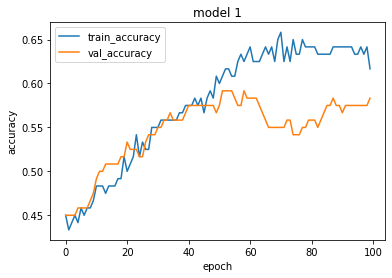

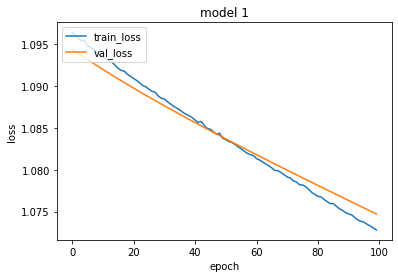

In [ ]:
plot_accuracy(historyf,'model 1')
plot_loss(historyf,'model 1')

**Model très volatile en termes d'accuracy, loss toujours en décroissance il faut plus d'épochs**

### Test the network on the test set

In [ ]:
score = modelf.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.0747182369232178 / Test accuracy: 0.5833333134651184


### Play with the architecture

> - Add 1 or 2 more fully connected layers (512 and 20 for exemple) with Relu and dropout ( https://keras.io/activations/ https://keras.io/layers/core/#dropout )

> - Switch the optimizer to adam ( https://keras.io/optimizers/ ). What do you observe ? why ?

> - Switch AveragePooling to MaxPooling

> - Replace l2 normalization with Bath norm.

> - Play with epochs and batch size

In [ ]:

from keras import optimizers
from keras import regularizers
from keras.layers import Input, BatchNormalization, concatenate, Reshape, Conv2DTranspose, Activation
input_shape = (14,14,512)

x = Input(shape=input_shape, name='input')
y0 = AveragePooling2D((14,14), padding='same')(x)# MaxPooling2D   AveragePooling2D ##### You may also use GlobalAveragePooling layers

y0 = Lambda(lambda x: K.l2_normalize(x, axis=-1))(y0)
y0 = Flatten()(y0)
y0 = Dense(512, activation=keras.activations.relu)(y0)
y0 = Dropout(0.5)(y0)
y0 = Dense(20, activation=keras.activations.relu)(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

modelll = Model(inputs=x,outputs=y1)

#Combine the networks VGG + 
model1 = Model(inputs=network2.input, outputs=modelll(network2.output))
model1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])



history1 = model1.fit(X_train, Y_train,validation_data = (X_test, Y_test) ,batch_size=40, epochs=100, verbose=1)




Epoch 1/100
3/3 [==============================] - 3s 1s/step - loss: 1.0967 - accuracy: 0.3583 - val_loss: 1.0963 - val_accuracy: 0.3417
Epoch 2/100
3/3 [==============================] - 2s 890ms/step - loss: 1.0974 - accuracy: 0.3583 - val_loss: 1.0959 - val_accuracy: 0.3250
Epoch 3/100
3/3 [==============================] - 2s 890ms/step - loss: 1.0985 - accuracy: 0.3250 - val_loss: 1.0956 - val_accuracy: 0.3583
Epoch 4/100
3/3 [==============================] - 2s 890ms/step - loss: 1.0916 - accuracy: 0.3750 - val_loss: 1.0952 - val_accuracy: 0.3500
Epoch 5/100
3/3 [==============================] - 2s 894ms/step - loss: 1.0961 - accuracy: 0.3833 - val_loss: 1.0949 - val_accuracy: 0.3583
Epoch 6/100
3/3 [==============================] - 2s 995ms/step - loss: 1.0945 - accuracy: 0.3500 - val_loss: 1.0944 - val_accuracy: 0.3667
Epoch 7/100
3/3 [==============================] - 2s 887ms/step - loss: 1.0908 - accuracy: 0.4250 - val_loss: 1.0941 - val_accuracy: 0.3750
Epoch 8/100
3/3 

In [ ]:
score = model1.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.0435210466384888 / Test accuracy: 0.6916666626930237


In [ ]:

#Adagrad sur model 2 = model 3
x = Input(shape=input_shape, name='input')
y0 = AveragePooling2D((14,14), padding='same')(x)# MaxPooling2D   
y0 = Lambda(lambda x: K.l2_normalize(x, axis=-1))(y0)
y0 = Flatten()(y0)
y0 = Dense(512, activation=keras.activations.relu)(y0)
y0 = Dropout(0.5)(y0)
y0 = Dense(20, activation=keras.activations.relu)(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

modelll = Model(inputs=x,outputs=y1)

#Combine the models (vgg + our neural)
model3 = Model(inputs=network2.input, outputs=modelll(network2.output))
model3.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])


history3 = model3.fit(X_train, Y_train,validation_data = (X_test, Y_test), batch_size=40, epochs=100, verbose=1)


score = model3.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/100
3/3 [==============================] - 3s 1s/step - loss: 1.1051 - accuracy: 0.3333 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 2/100
3/3 [==============================] - 2s 881ms/step - loss: 1.1043 - accuracy: 0.3250 - val_loss: 1.0997 - val_accuracy: 0.3333
Epoch 3/100
3/3 [==============================] - 2s 891ms/step - loss: 1.1050 - accuracy: 0.3167 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 4/100
3/3 [==============================] - 2s 992ms/step - loss: 1.1029 - accuracy: 0.3250 - val_loss: 1.0993 - val_accuracy: 0.3333
Epoch 5/100
3/3 [==============================] - 2s 994ms/step - loss: 1.1019 - accuracy: 0.3333 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 6/100
3/3 [==============================] - 2s 889ms/step - loss: 1.1025 - accuracy: 0.3250 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 7/100
3/3 [==============================] - 2s 889ms/step - loss: 1.1054 - accuracy: 0.3500 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 8/100
3/3 

In [ ]:

#Average pooling
x = Input(shape=input_shape, name='input')
y0 = AveragePooling2D((14,14), padding='same')(x)# MaxPooling2D   
y0 = Lambda(lambda x: K.l2_normalize(x, axis=-1))(y0)
y0 = Flatten()(y0)
y0 = Dense(512, activation=keras.activations.relu)(y0)
y0 = Dropout(0.5)(y0)
y0 = Dense(20, activation=keras.activations.relu)(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

modelll = Model(inputs=x,outputs=y1)

#Combine the models (vgg + our neural)
model4 = Model(inputs=network2.input, outputs=modelll(network2.output))
model4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])




history4 = model4.fit(X_train, Y_train,validation_data = (X_test, Y_test), batch_size=40, epochs=100, verbose=1)


score = model4.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/100
3/3 [==============================] - 3s 1s/step - loss: 1.1016 - accuracy: 0.3167 - val_loss: 1.0988 - val_accuracy: 0.3250
Epoch 2/100
3/3 [==============================] - 2s 885ms/step - loss: 1.0982 - accuracy: 0.3333 - val_loss: 1.0983 - val_accuracy: 0.3250
Epoch 3/100
3/3 [==============================] - 2s 891ms/step - loss: 1.1032 - accuracy: 0.3083 - val_loss: 1.0976 - val_accuracy: 0.3250
Epoch 4/100
3/3 [==============================] - 2s 887ms/step - loss: 1.0961 - accuracy: 0.3250 - val_loss: 1.0970 - val_accuracy: 0.3250
Epoch 5/100
3/3 [==============================] - 2s 997ms/step - loss: 1.1015 - accuracy: 0.3417 - val_loss: 1.0965 - val_accuracy: 0.3250
Epoch 6/100
3/3 [==============================] - 2s 892ms/step - loss: 1.0992 - accuracy: 0.3333 - val_loss: 1.0959 - val_accuracy: 0.3250
Epoch 7/100
3/3 [==============================] - 2s 886ms/step - loss: 1.0976 - accuracy: 0.3500 - val_loss: 1.0952 - val_accuracy: 0.3250
Epoch 8/100
3/3 

In [ ]:

#Batch norm au lieu de l2 norm
x = Input(shape=input_shape, name='input')
y0 = AveragePooling2D((14,14), padding='same')(x)# MaxPooling2D   
y0 = BatchNormalization()(y0)#y0 = Lambda(lambda x: K.l2_normalize(x, axis=-1))(y0)
y0 = Flatten()(y0)
y0 = Dense(512, activation=keras.activations.relu)(y0)
y0 = Dropout(0.5)(y0)
y0 = Dense(20, activation=keras.activations.relu)(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

modelll = Model(inputs=x,outputs=y1)

#Combine the models (vgg + our neural)
model5 = Model(inputs=network2.input, outputs=modelll(network2.output))
model5.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])



history5 = model5.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=40, epochs=100, verbose=1)


score = model5.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 1.3006 - accuracy: 0.3250 - val_loss: 11.1341 - val_accuracy: 0.2917
Epoch 2/100
3/3 [==============================] - 2s 885ms/step - loss: 1.1565 - accuracy: 0.4000 - val_loss: 5.7666 - val_accuracy: 0.3667
Epoch 3/100
3/3 [==============================] - 2s 891ms/step - loss: 1.0898 - accuracy: 0.4667 - val_loss: 4.2140 - val_accuracy: 0.3833
Epoch 4/100
3/3 [==============================] - 2s 888ms/step - loss: 0.9763 - accuracy: 0.5583 - val_loss: 2.8029 - val_accuracy: 0.4167
Epoch 5/100
3/3 [==============================] - 2s 889ms/step - loss: 0.8953 - accuracy: 0.6083 - val_loss: 2.3997 - val_accuracy: 0.4167
Epoch 6/100
3/3 [==============================] - 2s 891ms/step - loss: 0.7751 - accuracy: 0.6917 - val_loss: 2.1542 - val_accuracy: 0.4333
Epoch 7/100
3/3 [==============================] - 2s 887ms/step - loss: 0.7734 - accuracy: 0.7000 - val_loss: 1.7911 - val_accuracy: 0.4250
Epoch 8/100
3/3

### Report the architectures tested and the performance obtained.

### Modify the network 

> - Extract the first (then second) fully connected layer from the pre-trained vgg19 (There is no need for pooling and flatenning)

> - Compare your results to the convolutional layer


In [ ]:
#Model vgg complet 
#network.summary()

#first network with the first fully connected layer as a output
network_fc1 = Model(inputs=network.input, outputs=network.get_layer('fc1').output)#Use only the pre-trained convolutional layers
network_fc1.trainable = False

#Second network with the second fully connected layer as a output
network_fc2 = Model(inputs=network.input, outputs=network.get_layer('fc2').output)#Use only the pre-trained convolutional layers
network_fc2.trainable = False


In [ ]:
input_shape =network_fc1.output_shape


x = Input(shape=input_shape, name='input')

y0 = Dense(512, activation=keras.activations.relu)(x)
y0 = Dropout(0.5)(y0)
y0 = Dense(20, activation=keras.activations.relu)(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

modelll = Model(inputs=x,outputs=y1)

#Combine the models (vgg + our neural)
network_fc1_classif = Model(inputs=network_fc1.input, outputs=modelll(network_fc1.output))
network_fc1_classif.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])



history_fc1 = network_fc1_classif.fit(X_train, Y_train, validation_data = (X_test, Y_test),batch_size=40, epochs=100, verbose=1)

Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 20.5899 - accuracy: 0.3250 - val_loss: 1.1169 - val_accuracy: 0.3333
Epoch 2/100
3/3 [==============================] - 2s 980ms/step - loss: 1.2743 - accuracy: 0.3833 - val_loss: 1.0738 - val_accuracy: 0.4500
Epoch 3/100
3/3 [==============================] - 2s 973ms/step - loss: 1.0695 - accuracy: 0.3750 - val_loss: 1.0672 - val_accuracy: 0.5333
Epoch 4/100
3/3 [==============================] - 2s 971ms/step - loss: 1.0201 - accuracy: 0.4333 - val_loss: 1.0221 - val_accuracy: 0.6250
Epoch 5/100
3/3 [==============================] - 2s 975ms/step - loss: 0.9609 - accuracy: 0.5333 - val_loss: 0.9682 - val_accuracy: 0.6250
Epoch 6/100
3/3 [==============================] - 2s 980ms/step - loss: 0.9261 - accuracy: 0.5667 - val_loss: 0.8949 - val_accuracy: 0.6083
Epoch 7/100
3/3 [==============================] - 2s 1s/step - loss: 0.7445 - accuracy: 0.6583 - val_loss: 0.7833 - val_accuracy: 0.6250
Epoch 8/100
3/3 [=

In [ ]:
input_shape =network_fc2.output_shape
#Batch norm + adagrad + 
x = Input(shape=input_shape, name='input')

y0 = Dense(512, activation=keras.activations.relu)(x)
y0 = Dropout(0.5)(y0)
y0 = Dense(20, activation=keras.activations.relu)(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

modelll = Model(inputs=x,outputs=y1)

#Combine the models (vgg + our neural)
network_fc2_classif = Model(inputs=network_fc2.input, outputs=modelll(network_fc2.output))
network_fc2_classif.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])



history_fc2 =network_fc2_classif.fit(X_train, Y_train,validation_data = (X_test, Y_test), batch_size=40, epochs=100, verbose=1)



Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 1.0380 - accuracy: 0.5333 - val_loss: 0.6528 - val_accuracy: 0.7500
Epoch 2/100
3/3 [==============================] - 2s 994ms/step - loss: 0.6077 - accuracy: 0.7500 - val_loss: 0.5601 - val_accuracy: 0.8083
Epoch 3/100
3/3 [==============================] - 2s 1s/step - loss: 0.3898 - accuracy: 0.8750 - val_loss: 0.4650 - val_accuracy: 0.7917
Epoch 4/100
3/3 [==============================] - 2s 995ms/step - loss: 0.3095 - accuracy: 0.9000 - val_loss: 0.4859 - val_accuracy: 0.7833
Epoch 5/100
3/3 [==============================] - 2s 985ms/step - loss: 0.1958 - accuracy: 0.9500 - val_loss: 0.5044 - val_accuracy: 0.8000
Epoch 6/100
3/3 [==============================] - 2s 987ms/step - loss: 0.2027 - accuracy: 0.9333 - val_loss: 0.4956 - val_accuracy: 0.8083
Epoch 7/100
3/3 [==============================] - 2s 990ms/step - loss: 0.1636 - accuracy: 0.9417 - val_loss: 0.5346 - val_accuracy: 0.8083
Epoch 8/100
3/3 [==

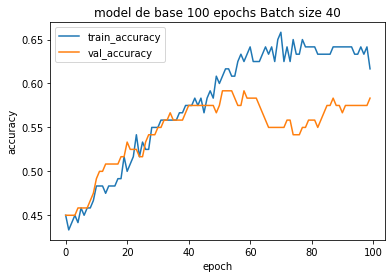

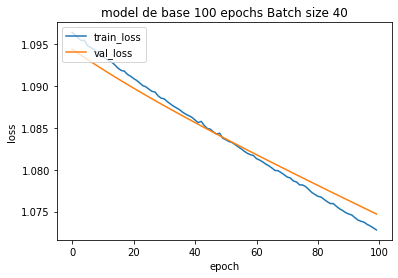

In [ ]:
dixionaire = {historyf : 'model de base 100 epochs Batch size 40',
 history1 : 'model proposed with additional layers',
 history3 : 'model 1 + Adagrad sur model 2',
 history4 : 'Average pooling ',
 history5 : 'batch normalization instead of L2 reg.',
 history_fc1 : 'vgg_fc_avant_dernier+classif+batchnorm',   # l'entrainement et la visualisation des modeles se fait après.
  history_fc2 : 'vgg_fc_dernier+ classif + batchnorm',
 }
plot_accuracy(historyf,dixionaire[historyf])
plot_loss(historyf,dixionaire[historyf])




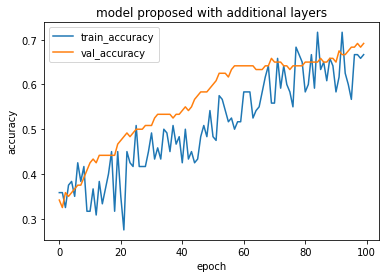

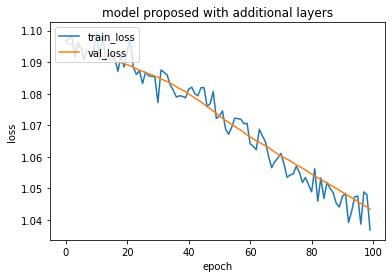

In [ ]:
plot_accuracy(history1,dixionaire[history1])
plot_loss(history1,dixionaire[history1])

## **Model très  dans la phase d'entrainement, loss toujours en décroissance il faut plus d'épochs**


## **Possibilité d'overfitt si on ajoute encore des epochs**

## **Preuve que juste stacker des layers n'améliore pas beaucoup les choses**

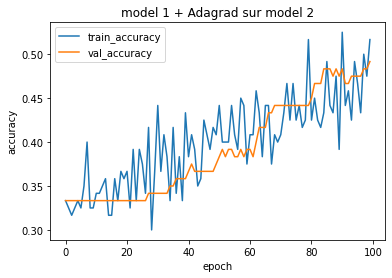

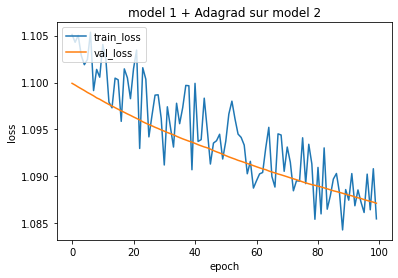

In [ ]:

plot_accuracy(history3,dixionaire[history3])
plot_loss(history3,dixionaire[history3])


## **Juste le changement d'optimizer entre model 2 et 3 , pas d'amélioration, mais au contraire avec adagrad la convergence est plus lente dans ce cas.**

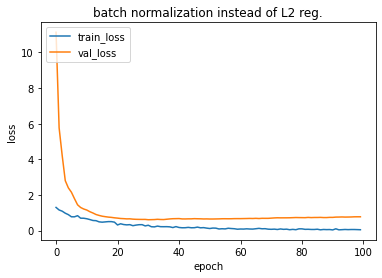

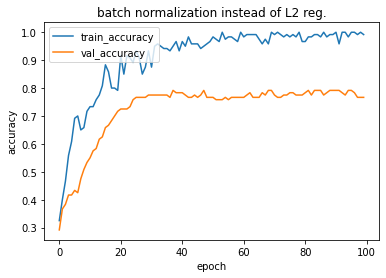

In [ ]:
plot_loss(history5,dixionaire[history5])
plot_accuracy(history5,dixionaire[history5])


## **Courbe magique, Le batch normalization au lieu de L2 regularization, a rendu la convergence plus rapide, pas de resique d'overfitt jusqu'à 100 epochs.**

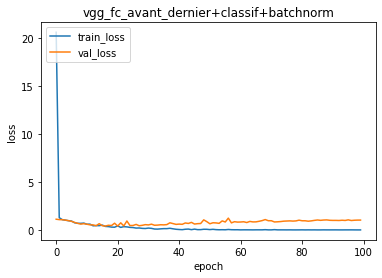

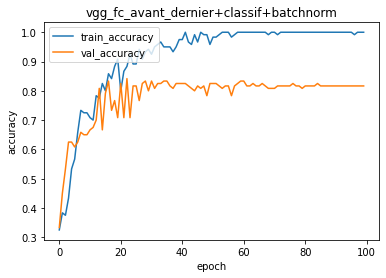

In [ ]:
plot_loss(history_fc1,dixionaire[history_fc1])
plot_accuracy(history_fc1,dixionaire[history_fc1])


## **Avec plus de couche de VGG et la BN la convergence devient extramement rapide, or il y a un risque de sur apprentissage dès les premiers epochs**

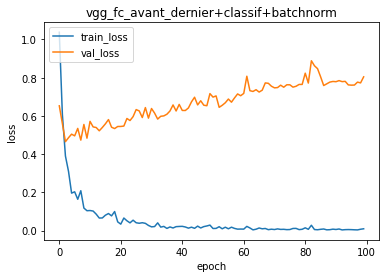

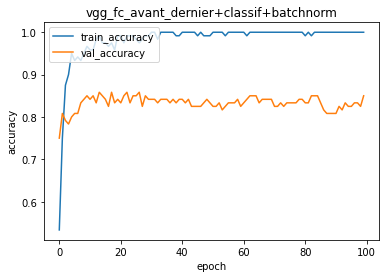

In [ ]:
plot_loss(history_fc2,dixionaire[history_fc2])
plot_accuracy(history_fc2,dixionaire[history_fc2])


**Overfitting du modèle dès les 4 premieres epochs.**

In [ ]:

score1 = network_fc1_classif.evaluate(X_test, Y_test, verbose=0)
score2 = network_fc2_classif.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score1[0]} / Test accuracy: {score1[1]}')
print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')

Test loss: 1.0255122184753418 / Test accuracy: 0.8166666626930237
Test loss: 0.8044988512992859 / Test accuracy: 0.8500000238418579


### Use another network

> - Choose another network, namely resnet, densenet, mobileNet, efficientNet...

> - Study its architecture

> - Similarly extract the final or penultimate convolutional layer, then add a couple of dense layers to perform classification. Compare performances with earlier networks.



In [ ]:
from keras.applications import xception


In [ ]:
network = xception.Xception(weights="imagenet")
network2 = Model(inputs=network.input, outputs=network.get_layer('avg_pool').output)#Use only the pre-trained convolutional layers

network2.trainable = False# this freezes the layers of this network, i.e. the layers will not be updated
network2.summary()

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
input_shape =network2.output_shape
#Batch norm + adagrad + 
x = Input(shape=input_shape, name='input')

y0 = Dense(512, activation=keras.activations.relu)(x)
y0 = Dropout(0.5)(y0)
y0 = Dense(20, activation=keras.activations.relu)(y0)

y0 = Dense(3)(y0)##
y1 = Activation('softmax')(y0)

classif = Model(inputs=x,outputs=y1)

#Combine the models (vgg + our neural)
Xception_classif = Model(inputs=network2.input, outputs=classif(network2.output))
Xception_classif.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Xception_classif.summary()

Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
# un resize pour nos images est nécessaire puisque Xception a pour dim d'entrée (224;224)
# pour ceci j'ajoute un resize sur la boucle de création de X
import cv2

X_train = np.zeros(shape=(40*3,299,299,3), dtype=np.float32)# train batch

Y_train = np.zeros(shape=(40*3,3))
Y_train[0:40,0]=1
Y_train[40:80,1]=1
Y_train[80:120,2]=1

def flow_data_resized(dir,X):
  listDir = sorted(os.listdir(dir))
  print(listDir)

  cpt = 0
  for d in listDir:
    #read subfolder
    listFiles = sorted(os.listdir(dir_path+'/'+d))
    print(d)
    print(len(listFiles))

    for f in listFiles:
      img = image.load_img(dir_path+'/'+d+'/'+f, target_size=(299,299))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      X[cpt,:,:,:] = x[0,:,:,:]
      cpt+=1
  return X



X_train = flow_data_resized('/content/drive/MyDrive/ECM/ComputerVision/miniMIT_Etus/train/',X_train)


['bookstore', 'inside_bus', 'library']
bookstore
40
inside_bus
40
library
40


In [ ]:

import cv2


X_test = np.zeros(shape=(40*3,299,299,3), dtype=np.float32)# test batch

Y_test = np.zeros(shape=(40*3,3))
Y_test[0:40,0]=1
Y_test[40:80,1]=1
Y_test[80:120,2]=1




X_test = flow_data_resized('/content/drive/MyDrive/ECM/ComputerVision/miniMIT_Etus/test',X_test)



['bookstore', 'inside_bus', 'library']
bookstore
40
inside_bus
40
library
40


In [ ]:
history_Xception_classif =Xception_classif.fit(X_train, Y_train,validation_data = (X_test, Y_test), batch_size=40, epochs=100, verbose=1)


Epoch 1/100
3/3 [==============================] - 10s 2s/step - loss: 2.6900 - accuracy: 0.3417 - val_loss: 1.0939 - val_accuracy: 0.3833
Epoch 2/100
3/3 [==============================] - 4s 2s/step - loss: 1.1263 - accuracy: 0.4250 - val_loss: 1.0330 - val_accuracy: 0.4750
Epoch 3/100
3/3 [==============================] - 4s 2s/step - loss: 1.1815 - accuracy: 0.4417 - val_loss: 1.0202 - val_accuracy: 0.5250
Epoch 4/100
3/3 [==============================] - 4s 2s/step - loss: 1.0425 - accuracy: 0.5167 - val_loss: 0.9436 - val_accuracy: 0.5917
Epoch 5/100
3/3 [==============================] - 4s 2s/step - loss: 1.0057 - accuracy: 0.5500 - val_loss: 0.9585 - val_accuracy: 0.5833
Epoch 6/100
3/3 [==============================] - 4s 2s/step - loss: 0.9816 - accuracy: 0.5250 - val_loss: 0.9100 - val_accuracy: 0.5917
Epoch 7/100
3/3 [==============================] - 4s 2s/step - loss: 1.0479 - accuracy: 0.4667 - val_loss: 0.8771 - val_accuracy: 0.5917
Epoch 8/100
3/3 [================

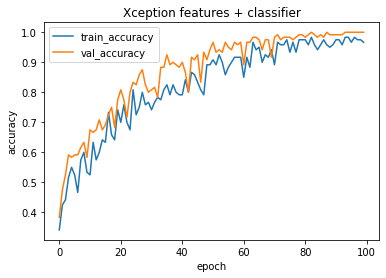

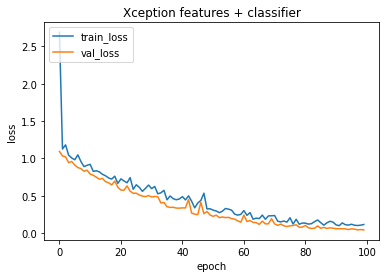

In [ ]:
plot_accuracy(history_Xception_classif,'Xception features + classifier')
plot_loss(history_Xception_classif,'Xception features + classifier')